# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.691097,False,0.691424
1,-0.448272,False,-0.217374
2,-2.412139,False,1.053742
3,-1.188220,False,1.074310
4,-2.212989,False,-0.361335
...,...,...,...
995,-0.463786,False,0.031443
996,-1.423323,False,1.171860
997,0.832790,True,3.520931
998,-0.071081,False,0.333575


<AxesSubplot: xlabel='v0'>

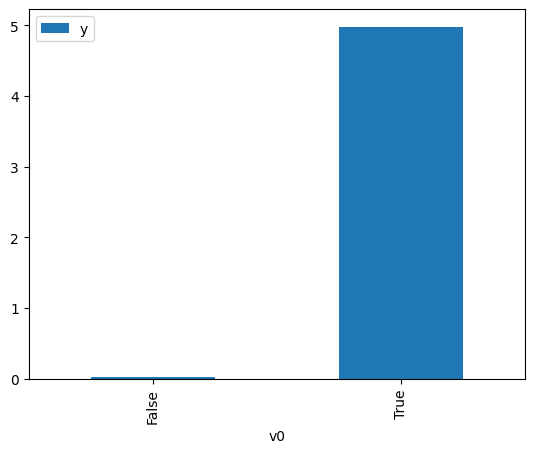

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

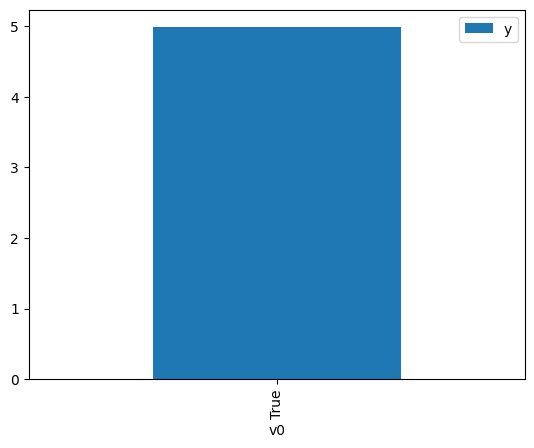

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.133282,False,0.531365,0.233673,4.279487
1,0.536701,False,-0.239088,0.421442,2.372806
2,-0.662567,False,0.709526,0.583526,1.713719
3,0.305695,False,-1.023361,0.452430,2.210287
4,0.415776,False,0.795680,0.437602,2.285181
...,...,...,...,...,...
995,-0.621371,False,-0.952019,0.578056,1.729937
996,1.311267,False,1.252440,0.323150,3.094535
997,0.340126,False,1.395723,0.447782,2.233231
998,-0.495274,False,-0.950205,0.561196,1.781908


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.456924,True,4.439097,0.443961,2.252450
1,-2.963949,True,3.446003,0.169030,5.916122
2,0.923600,True,4.040224,0.628990,1.589852
3,-1.059315,True,4.918350,0.365014,2.739619
4,0.326443,True,5.527318,0.550372,1.816953
...,...,...,...,...,...
995,-0.483016,True,5.002124,0.440451,2.270401
996,-0.894778,True,5.644745,0.386056,2.590299
997,0.321376,True,4.571422,0.549688,1.819213
998,0.208873,True,4.420072,0.534457,1.871057


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.916
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              5425.
Date:                Sat, 03 Dec 2022   Prob (F-statistic):                        0.00
Time:                        17:35:39   Log-Likelihood:                         -1439.7
No. Observations:                1000   AIC:                                      2883.
Df Residuals:                     998   BIC:                                      2893.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0823      0.030      2.711      0.007       0.023       0.142
x2             5.0053      0.048    103.975      0.000       4.911       5.100
==============================================================================
Omnibus:                        2.645   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.266   Jarque-Bera (JB):                2.715
Skew:                           0.119   Prob(JB):                        0.257
Kurtosis:                       2.907   Cond. No.                         1.60
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""